## 1. **Environment Setup & Library Imports**
Install the necessary packages and import all standard, visualization, audio processing, and machine learning libraries required for data preparation, model training, and evaluation.

In [ ]:
# Install required packages.
!pip install tensorflow
!pip install antropy
!pip install pydub

# Standard libraries
import os
import warnings
import numpy as np
import pandas as pd
import pickle
from statistics import mode

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import IPython
import plotly.express as px
import plotly.graph_objects as go

# Audio processing libraries
import librosa
import librosa.display
from pydub import AudioSegment
from pydub.silence import split_on_silence

# Additional specialized libraries
from antropy import spectral_entropy

# Keras & TensorFlow utilities (using TensorFlow's bundled Keras)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

# Scikit-learn for preprocessing and model evaluation
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             f1_score, multilabel_confusion_matrix, precision_score, recall_score)
from sklearn.model_selection import train_test_split

# Progress bar
from tqdm.auto import tqdm

# Ignore warnings
warnings.filterwarnings('ignore')

## 2. **Mount Drive & Unzip Datasets**  
Authenticate Google Drive access, extract all five emotion datasets into the Colab environment, and define path variables for each dataset directory.  


In [ ]:
# 1. Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Create a local directory for the datasets
!mkdir -p /content/input

# 3. Unzip the datasets from your Drive.
!unzip -o "/content/drive/My Drive/Datasets/RAVDESS.zip" -d /content/input/ravdessemotionalspeechaudio
!unzip -o "/content/drive/My Drive/Datasets/CREMA-D.zip" -d /content/input/cremad
!unzip -o "/content/drive/My Drive/Datasets/SAVEE.zip" -d /content/input/surrey-audiovisual-expressed-emotion-savee
!unzip -o "/content/drive/My Drive/Datasets/TESS.zip" -d /content/input/torontoemotionalspeechsettess
!unzip -o "/content/drive/My Drive/Datasets/IEMOCAP.zip" -d /content/input/iemocap

# 4. Set the dataset paths based on the extracted folder structure.
RAVDESS_PATH  = '/content/input/ravdessemotionalspeechaudio'
CREMAD_PATH   = '/content/input/cremad/AudioWAV/'
SAVEE_PATH    = '/content/input/surrey-audiovisual-expressed-emotion-savee/ALL/'
TESS_PATH     = '/content/input/torontoemotionalspeechsettess'
IEMOCAP_PATH  = '/content/input/iemocap'

print("Dataset Paths:")
print("RAVDESS_PATH:", RAVDESS_PATH)
print("CREMAD_PATH:", CREMAD_PATH)
print("SAVEE_PATH:", SAVEE_PATH)
print("TESS_PATH:", TESS_PATH)
print("IEMOCAP_PATH:", IEMOCAP_PATH)

Streaming output truncated to the last 5000 lines.
  inflating: /content/input/iemocap/Frustration/Ses04M_impro05_M007.wav  
  inflating: /content/input/iemocap/Frustration/Ses04M_impro05_M012.wav  
  inflating: /content/input/iemocap/Frustration/Ses04M_impro05_M013.wav  
  inflating: /content/input/iemocap/Frustration/Ses04M_impro05_M020.wav  
  inflating: /content/input/iemocap/Frustration/Ses04M_impro05_M021.wav  
  inflating: /content/input/iemocap/Frustration/Ses04M_impro05_M023.wav  
  inflating: /content/input/iemocap/Frustration/Ses04M_impro05_M024.wav  
  inflating: /content/input/iemocap/Frustration/Ses04M_impro05_M025.wav  
  inflating: /content/input/iemocap/Frustration/Ses04M_impro05_M027.wav  
  inflating: /content/input/iemocap/Frustration/Ses04M_impro05_M028.wav  
  inflating: /content/input/iemocap/Frustration/Ses04M_impro05_M029.wav  
  inflating: /content/input/iemocap/Frustration/Ses04M_impro05_M030.wav  
  inflating: /content/input/iemocap/Frustration/Ses04M_impro0

## 3. **Load & Sample Audio Files**  
Scan all five datasets (RAVDESS, CREMA‑D, SAVEE, TESS, IEMOCAP), map their native emotion codes to a common set (`happy`, `sad`, `angry`, `neutral`), and randomly select up to 150 clips per emotion to create a balanced DataFrame.  

In [ ]:
# Load 150 samples per emotion from each dataset
import glob
import random

data = []

# Define a simplified emotion map
target_emotions = ['happy', 'sad', 'angry', 'neutral']
emotion_map_ravdess = {
    "01": "neutral", "03": "happy", "04": "sad", "05": "angry"
}
emotion_map_crema = {
    "NEU": "neutral", "HAP": "happy", "SAD": "sad", "ANG": "angry"
}
emotion_map_savee = {
    "a": "angry", "h": "happy", "n": "neutral", "s": "sad"
}
emotion_map_tess = {
    "angry": "angry", "happy": "happy", "neutral": "neutral", "sad": "sad"
}
emotion_map_iemocap = {
    "ang": "angry", "hap": "happy", "neu": "neutral", "sad": "sad"
}

# --------- RAVDESS ----------
rav_files = glob.glob(RAVDESS_PATH + "/*.wav")
for file in rav_files:
    emotion_code = file.split("-")[2]
    emotion = emotion_map_ravdess.get(emotion_code)
    if emotion in target_emotions:
        data.append([file, emotion])

# --------- CREMA-D ----------
crema_files = glob.glob(CREMAD_PATH + "/*.wav")
for file in crema_files:
    parts = os.path.basename(file).split('_')
    if len(parts) >= 3:
        emotion_code = parts[2]
        emotion = emotion_map_crema.get(emotion_code)
        if emotion in target_emotions:
            data.append([file, emotion])

# --------- SAVEE ----------
savee_files = glob.glob(SAVEE_PATH + "/*.wav")
for file in savee_files:
    basename = os.path.basename(file)
    code = basename[0].lower()
    emotion = emotion_map_savee.get(code)
    if emotion in target_emotions:
        data.append([file, emotion])

# --------- TESS ----------
tess_folders = glob.glob(TESS_PATH + "/*")
for folder in tess_folders:
    emotion = os.path.basename(folder).lower()
    for file in glob.glob(folder + "/*.wav"):
        mapped = emotion_map_tess.get(emotion)
        if mapped in target_emotions:
            data.append([file, mapped])

# --------- IEMOCAP ----------
# Only process wav files and infer emotion from parent folders
iemocap_emotions = ['Anger', 'Happiness', 'Neutral', 'Sadness']
for emo in iemocap_emotions:
    path = os.path.join(IEMOCAP_PATH, emo)
    if os.path.exists(path):
        for file in glob.glob(path + "/*.wav"):
            mapped = emo.lower()
            if mapped in emotion_map_iemocap.values():
                data.append([file, mapped])

# Shuffle and take a balanced subset
df = pd.DataFrame(data, columns=['filepath', 'emotion'])
df = df[df['emotion'].isin(target_emotions)]

# Limit to ~150 samples per emotion
df = df.groupby('emotion').apply(lambda x: x.sample(n=min(150, len(x)), random_state=42)).reset_index(drop=True)

print("Samples per emotion:\n", df['emotion'].value_counts())
df

Samples per emotion:
 emotion
angry      150
happy      150
neutral    150
sad        150
Name: count, dtype: int64


,filepath,emotion
0,/content/input/cremad/AudioWAV/1006_TIE_ANG_XX...,angry
1,/content/input/cremad/AudioWAV/1003_WSI_ANG_XX...,angry
2,/content/input/cremad/AudioWAV/1045_WSI_ANG_XX...,angry
3,/content/input/cremad/AudioWAV/1015_IEO_ANG_MD...,angry
4,/content/input/cremad/AudioWAV/1033_WSI_ANG_XX...,angry
...,...,...
595,/content/input/cremad/AudioWAV/1014_TSI_SAD_XX...,sad
596,/content/input/cremad/AudioWAV/1039_DFA_SAD_XX...,sad
597,/content/input/cremad/AudioWAV/1034_IEO_SAD_HI...,sad
598,/content/input/cremad/AudioWAV/1006_TIE_SAD_XX...,sad


## 4. **Data Distribution & Duration Analysis**  
Calculate each audio clip’s duration and visualize the dataset balance (bar chart of sample counts per emotion) along with the variability in clip lengths across emotions (violin plot).


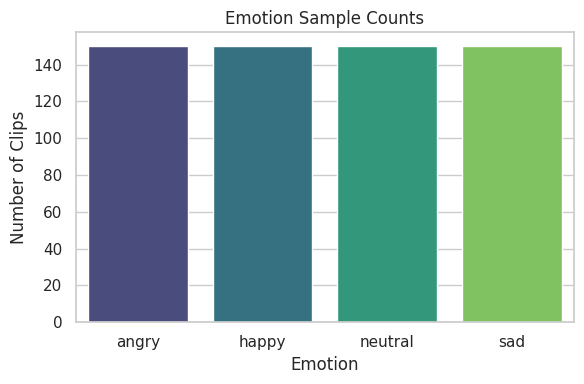

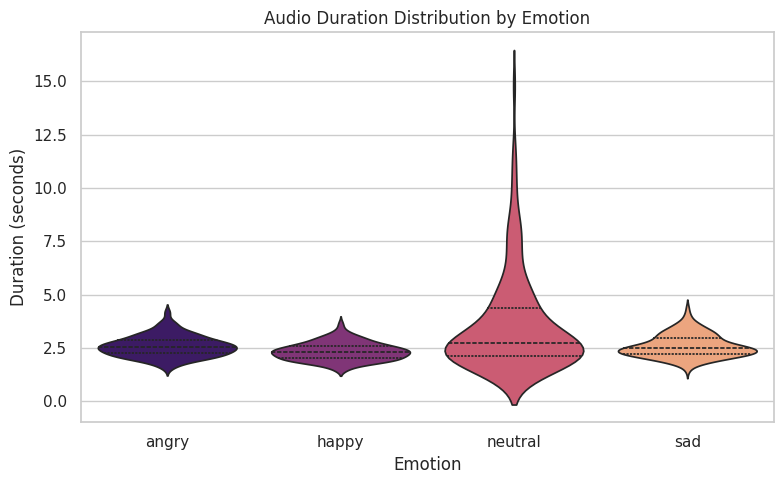

In [ ]:
# Ensure your DataFrame `df` (with 'filepath' & 'emotion') is loaded first.
import numpy as np
np.complex = complex        # Workaround for librosa compatibility
import librosa
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 1) Compute duration for each audio file
df['duration'] = df['filepath'].apply(lambda f: librosa.get_duration(filename=f))

# 2) Bar chart: count of samples per emotion
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='emotion', palette='viridis',
              order=df['emotion'].value_counts().index)
plt.title("Emotion Sample Counts")
plt.xlabel("Emotion")
plt.ylabel("Number of Clips")
plt.tight_layout()
plt.show()

# 3) Violin plot: distribution of clip durations by emotion
plt.figure(figsize=(8,5))
sns.violinplot(data=df, x='emotion', y='duration', palette='magma',
               order=df['emotion'].value_counts().index, inner='quartile')
plt.title("Audio Duration Distribution by Emotion")
plt.xlabel("Emotion")
plt.ylabel("Duration (seconds)")
plt.tight_layout()
plt.show()

## 5. **Log‑Mel Spectrogram Examples by Emotion**  
Display one representative log‑Mel spectrogram for each of the four emotions (angry, happy, neutral, sad) to highlight the distinct time–frequency patterns used by the model for classification.


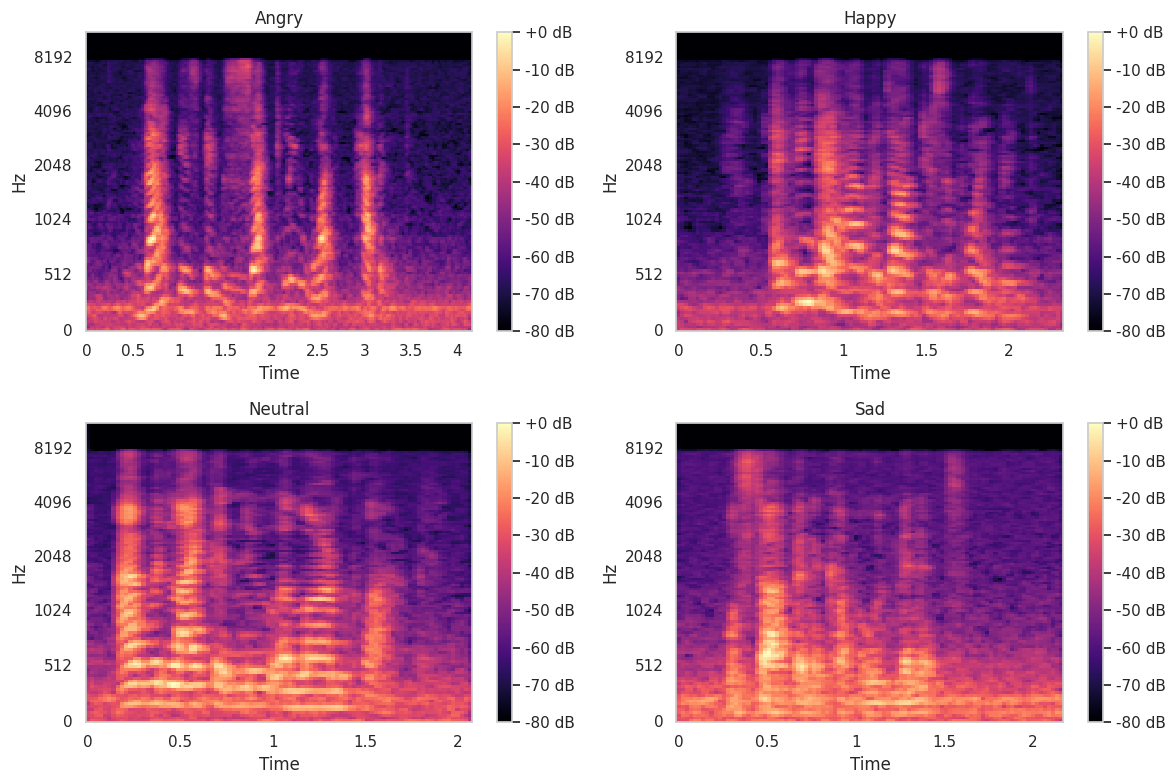

In [ ]:
import numpy as np
np.complex = complex        # Fix for librosa compatibility

import librosa
import librosa.display
import matplotlib.pyplot as plt

# ─── Log‑Mel Spectrograms for Each Emotion ──────────────────────────────────

# Emotions to visualize
emotions = ['angry', 'happy', 'neutral', 'sad']

plt.figure(figsize=(12, 8))

for i, emo in enumerate(emotions, start=1):
    # Select the first clip for this emotion
    fp = df[df['emotion'] == emo]['filepath'].iloc[0]

    # Load and compute log‑Mel
    y, sr = librosa.load(fp, sr=22050)
    S     = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    log_S = librosa.power_to_db(S, ref=np.max)

    # Plot in subplot
    plt.subplot(2, 2, i)
    librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
    plt.title(f"{emo.capitalize()}")
    plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

## 6. **Feature Extraction: Log‑Mel Spectrograms**  
Convert each audio file into a 128×128 log‑Mel spectrogram, normalize the values for NN input, and encode the emotion labels for training.  


In [ ]:
# Feature extraction (Log-Mel Spectrograms)
import librosa
import cv2
import numpy as np

# Log-Mel function
def extract_logmel(path, sr=22050, n_mels=128):
    y, sr = librosa.load(path, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    logmel = librosa.power_to_db(mel)
    return logmel

# Resize or pad spectrograms
def pad_or_resize(logmel, target_shape=(128, 128)):
    return cv2.resize(logmel, target_shape)

# Extract features
X = []
y = []

for i, row in df.iterrows():
    try:
        logmel = extract_logmel(row['filepath'])
        padded = pad_or_resize(logmel)
        X.append(padded)
        y.append(row['emotion'])
    except Exception as e:
        print(f"Error processing {row['filepath']}: {e}")

X = np.array(X)[..., np.newaxis] / 255.0  # Normalize and add channel dimension
print("Shape of X:", X.shape)

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Encoded labels:", np.unique(y_encoded))

Shape of X: (600, 128, 128, 1)
Encoded labels: [0 1 2 3]


## 7. **Model Definition & Training**  
Split the spectrogram features into train/validation sets, define a simple 2‑layer CNN with dropout for emotion classification, compile with Adam optimizer and sparse categorical cross‑entropy, then train for 10 epochs while monitoring validation accuracy.


In [ ]:
# Define and train CNN model
from tensorflow.keras import layers, models

# Split into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Build CNN model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 898ms/step - accuracy: 0.3105 - loss: 1.3701 - val_accuracy: 0.6500 - val_loss: 0.9532
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 771ms/step - accuracy: 0.5078 - loss: 1.0931 - val_accuracy: 0.6583 - val_loss: 0.8779
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 873ms/step - accuracy: 0.5720 - loss: 0.9156 - val_accuracy: 0.6417 - val_loss: 0.8118
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 779ms/step - accuracy: 0.6234 - loss: 0.8888 - val_accuracy: 0.7167 - val_loss: 0.7761
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 761ms/step - accuracy: 0.6558 - loss: 0.8312 - val_accuracy: 0.7167 - val_loss: 0.7273
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 872ms/step - accuracy: 0.7249 - loss: 0.7215 - val_accuracy: 0.7083 - val_loss: 0.7126
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 714ms/step - accuracy: 0.7676 - loss: 0.6550 - val_accuracy: 0.7250 - val_loss: 0.6698
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 881ms/step - accuracy: 0.7808 - loss: 0.5996 - val_accu

## 8. **Training Curves**  
Visualize training and validation accuracy and loss with bright, clean matplotlib style graphs.


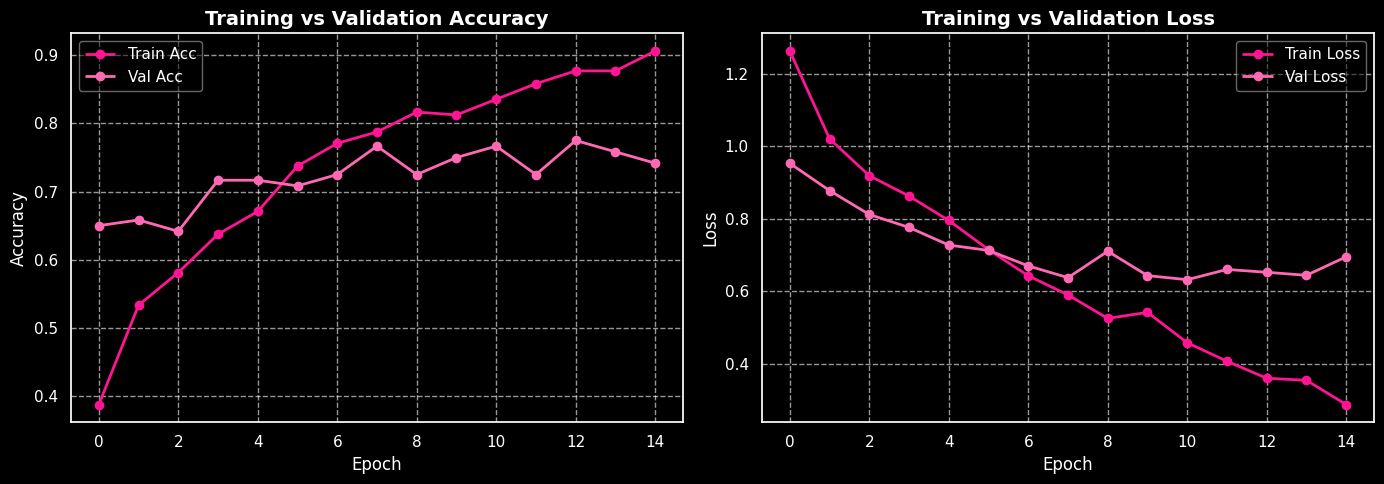

In [ ]:
import matplotlib.pyplot as plt

# Bright pink side-by-side training curves with black background
fig, axs = plt.subplots(1, 2, figsize=(14, 5), facecolor='black')

# Common styling for axes
for ax in axs:
    ax.set_facecolor('black')
    ax.title.set_color('white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(colors='white')
    for spine in ax.spines.values():
        spine.set_edgecolor('white')

# Accuracy subplot
axs[0].plot(history.history['accuracy'], marker='o', color='#FF1493', label='Train Acc')
axs[0].plot(history.history['val_accuracy'], marker='o', color='#FF69B4', label='Val Acc')
axs[0].set_title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
axs[0].set_xlabel('Epoch', fontsize=12)
axs[0].set_ylabel('Accuracy', fontsize=12)
axs[0].legend(facecolor='black', framealpha=0.5, labelcolor='white')
axs[0].grid(True, linestyle='--', alpha=0.6, color='white')

# Loss subplot
axs[1].plot(history.history['loss'], marker='o', color='#FF1493', label='Train Loss')
axs[1].plot(history.history['val_loss'], marker='o', color='#FF69B4', label='Val Loss')
axs[1].set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
axs[1].set_xlabel('Epoch', fontsize=12)
axs[1].set_ylabel('Loss', fontsize=12)
axs[1].legend(facecolor='black', framealpha=0.5, labelcolor='white')
axs[1].grid(True, linestyle='--', alpha=0.6, color='white')

plt.tight_layout()
plt.show()

## 9. **Confusion Matrix Visualization**  
Display a confusion matrix on a clean white background to highlight how the model’s predictions align with true emotion labels on the validation set.

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


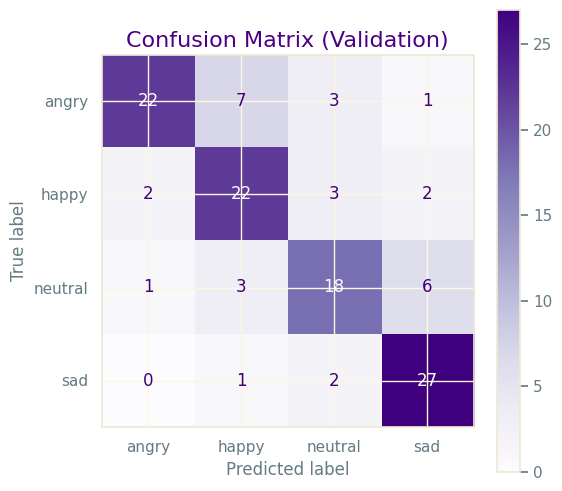

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure model, X_val, y_val, and label encoder 'le' are defined
if 'model' not in globals() or 'X_val' not in globals() or 'y_val' not in globals() or 'le' not in globals():
    raise NameError("Please ensure 'model', 'X_val', 'y_val', and 'le' are defined before plotting.")

# Predict on validation set
y_pred = model.predict(X_val).argmax(axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred, labels=range(len(le.classes_)))
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)

# Plot confusion matrix with purple colormap on white background
fig, ax = plt.subplots(figsize=(6, 6), facecolor='white')
ax.set_facecolor('white')
disp.plot(cmap='Purples', values_format='d', ax=ax)
ax.set_title('Confusion Matrix (Validation)', color='#4B0082')
plt.show()

## 10. **Save Trained Model & Encoder to Google Drive**  
Mount Google Drive and export the trained CNN model (`.h5`) and LabelEncoder (`.pkl`) directly to the Drive for persistent storage and easy reuse in future sessions.


In [ ]:
# Mount Drive if not already mounted
from google.colab import drive
drive.mount('/content/drive')

# Save model and encoder directly to Drive
model.save("/content/drive/MyDrive/emotion_cnn_model.h5")

import joblib
joblib.dump(le, "/content/drive/MyDrive/label_encoder.pkl")

print("Model and encoder saved successfully to Google Drive.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model and encoder saved successfully to Google Drive.


## 11. **Inference Function for Unseen Audio**  
Define `predict_emotion()` to process a new audio file end-to-end: extract its log‑Mel spectrogram, resize and normalize it, run the trained CNN model, and decode the predicted emotion label.


In [ ]:
# Inference on unseen audio file
def predict_emotion(audio_path):
    try:
        logmel = extract_logmel(audio_path)
        padded = pad_or_resize(logmel)
        input_tensor = np.expand_dims(padded, axis=(0, -1)) / 255.0
        pred = model.predict(input_tensor)
        return le.inverse_transform([np.argmax(pred)])[0]
    except Exception as e:
        print("Prediction error:", e)
        return None

In [ ]:
def prepare_spectrogram(fp, duration=3.0):
    y, sr = librosa.load(fp, sr=22050, duration=duration)
    y, _  = librosa.effects.trim(y, top_db=30)
    y     = y / np.max(np.abs(y))
    S     = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
    return librosa.power_to_db(S, ref=np.max)

# Then regenerate both spectrograms with prepare_spectrogram()
# and plot side by side with identical axes and color scales.

## 13. **Inference & Spectrogram Comparison**  
Upload any audio file, convert it to WAV, predict its emotion, then display side‑by‑side log‑Mel spectrograms of the uploaded clip and a representative sample from my dataset using the same dB scale for direct comparison.


▶ Upload an audio file (any format):


Saving Reem_Happy.ogg to Reem_Happy (1).ogg

🎵 Playing uploaded audio: Reem_Happy (1).wav


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Predicted emotion: happy


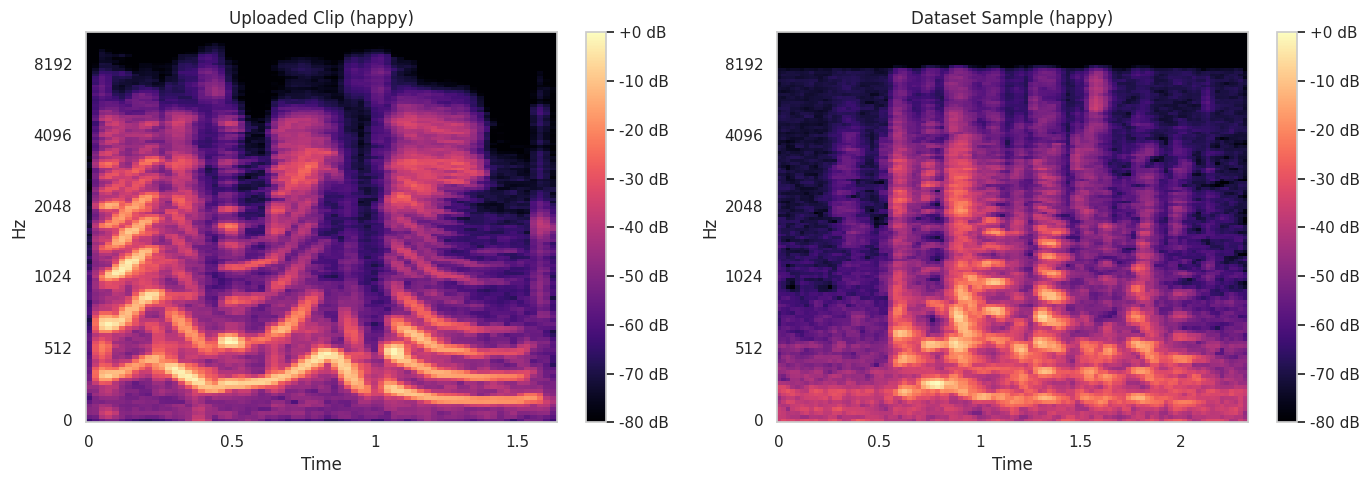

In [ ]:
import os
import numpy as np
np.complex = complex                # Fix for librosa compatibility
import librosa
import librosa.display
import matplotlib.pyplot as plt
from google.colab import files
from pydub import AudioSegment
from IPython.display import Audio, display

# ——— Helper Functions ——————————————————————————————————————

def convert_to_wav(uploaded_filename):
    """
    Convert any audio file to WAV and return the new path.
    """
    name, ext = os.path.splitext(uploaded_filename)
    ext = ext.lower()
    if ext != ".wav":
        sound = AudioSegment.from_file(uploaded_filename)
        wav_path = f"{name}.wav"
        sound.export(wav_path, format="wav")
        return wav_path
    return uploaded_filename

def prepare_spectrogram(fp, sr=22050, n_mels=128, duration=3.0, top_db=30):
    """
    Load, trim silence, normalize, and compute a log‑Mel spectrogram.
    """
    y, _ = librosa.load(fp, sr=sr, duration=duration)
    y, _ = librosa.effects.trim(y, top_db=top_db)
    if np.max(np.abs(y)) > 0:
        y = y / np.max(np.abs(y))
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    return librosa.power_to_db(S, ref=np.max)

# ——— 1) Upload & Convert ————————————————————————————————————

print("▶ Upload an audio file (any format):")
uploaded = files.upload()
uploaded_filename = next(iter(uploaded.keys()))
wav_file = convert_to_wav(uploaded_filename)

# ——— 2) Play & Predict ————————————————————————————————————

print(f"\n🎵 Playing uploaded audio: {wav_file}")
display(Audio(wav_file))

pred_emotion = predict_emotion(wav_file)
print("Predicted emotion:", pred_emotion)

# ——— 3) Compute Spectrograms ——————————————————————————————

logmel_up_db   = prepare_spectrogram(wav_file)
# get a dataset sample for the same emotion
sample_fp      = df[df['emotion'] == pred_emotion]['filepath'].iloc[0]
logmel_samp_db = prepare_spectrogram(sample_fp)

# ——— 4) Plot Side‑by‑Side Comparison —————————————————————————

vmin, vmax = -80, 0
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
librosa.display.specshow(logmel_up_db, sr=22050, x_axis='time', y_axis='mel',
                         vmin=vmin, vmax=vmax)
plt.title(f"Uploaded Clip ({pred_emotion})")
plt.colorbar(format='%+2.0f dB')

plt.subplot(1, 2, 2)
librosa.display.specshow(logmel_samp_db, sr=22050, x_axis='time', y_axis='mel',
                         vmin=vmin, vmax=vmax)
plt.title(f"Dataset Sample ({pred_emotion})")
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

## 14. **Live Audio Recording With Predicted Emotion**

Set duration and record audio using Google Colab Microphone and see the predicted emotion

In [ ]:
import base64
from google.colab import output
import IPython.display as ipd
import ipywidgets as widgets
from IPython.display import display
import librosa
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Existing helper functions
def extract_logmel(path, sr=22050, n_mels=128):
    y, sr = librosa.load(path, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    logmel = librosa.power_to_db(mel)
    return logmel

def pad_or_resize(logmel, target_shape=(128, 128)):
    return cv2.resize(logmel, target_shape)

def predict_emotion(path):
    logmel = extract_logmel(path)
    padded = pad_or_resize(logmel)
    input_tensor = np.expand_dims(padded, axis=(0, -1)) / 255.0
    pred = model.predict(input_tensor)
    return le.inverse_transform([np.argmax(pred)])[0]

# Function to record audio via browser mic
def record_audio(duration):
    print(f"Recording for {duration} seconds... Please speak into your microphone.")
    audio_data = output.eval_js(f"""
        new Promise(async resolve => {{
          const stream = await navigator.mediaDevices.getUserMedia({{audio: true}});
          const recorder = new MediaRecorder(stream);
          const data = [];
          recorder.ondataavailable = event => data.push(event.data);
          recorder.start(1000);
          await new Promise(r => setTimeout(r, {int(duration * 1000) + 500}));
          recorder.stop();
          recorder.onstop = () => {{
            let blob = new Blob(data, {{ type: 'audio/wav' }});
            let reader = new FileReader();
            reader.readAsDataURL(blob);
            reader.onloadend = () => resolve(reader.result);
          }};
        }});
    """)
    return audio_data

def save_recording(audio_data, filename="recorded_audio.wav"):
    header, encoded = audio_data.split(',', 1)
    data = base64.b64decode(encoded)
    with open(filename, "wb") as f:
        f.write(data)
    return filename

# Widgets for user input
duration_widget = widgets.FloatText(value=3.0, description="Duration (sec):", disabled=False)
record_button = widgets.Button(description="🎤 Start Recording")
output_label = widgets.Label()

def on_record_button_clicked(b):
    duration = duration_widget.value
    audio_data = record_audio(duration)
    recorded_filename = save_recording(audio_data, "recorded_audio.wav")
    display(ipd.Audio(recorded_filename))  # Play back the recording
    predicted_emotion = predict_emotion(recorded_filename)
    output_label.value = f"Predicted Emotion: {predicted_emotion}"

record_button.on_click(on_record_button_clicked)
display(duration_widget, record_button, output_label)

FloatText(value=3.0, description='Duration (sec):')

Button(description='🎤 Start Recording', style=ButtonStyle())

Label(value='')

Recording for 3.0 seconds... Please speak into your microphone.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
